# Data and Library Imports


In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.1 MB/s eta 0:00:00


In [2]:
from IPython import get_ipython
from IPython.display import display

In [24]:
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import geopandas as gpd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [4]:
!pip install tensorflow

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input

In [6]:
from google.colab import drive
drive.mount('/content/drive',)

Mounted at /content/drive


In [7]:
%cd drive/MyDrive/ENGO_645/ENGO_645_Project_W2025/

/content/drive/MyDrive/ENGO_645/ENGO_645_Project_W2025


#Train Test Split

In [39]:
tif_files_and_Geophys = [
    'Data/Soil_Geochem/Soil_IDW_As/Soil_IDW_As.tif',  #Arsenic
    'Data/Soil_Geochem/Soil_IDW_Au/Soil_IDW_Au.tif',  #Gold
    'Data/Soil_Geochem/Soil_IDW_Hg/Soil_IDW_Hg.tif',  #Mercury
    'Data/Soil_Geochem/Soil_IDW_Sb/Soil_IDW_Sb.tif',  #Antimony
    'Data/Soil_Geochem/Soil_IDW_Te/Soil_IDW_Te.tif',  #Tellurium
    'Data/Geophysical_Anomaly/GeoPhysAnomaly_DONE.tif', #Geophysical Anomaly
    'Data/Fault_data/Structures_Raster.tif'           #Fault data
]

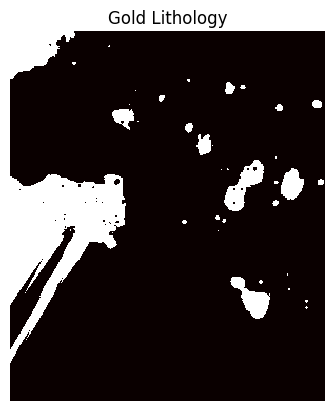

In [40]:
#setting label or target of model
with rasterio.open("Data/Gold_Litho_0_4/Gold_litho_zero_to_four.tif") as src:
    gold_labels = src.read(1)
    transform = src.transform
plt.imshow(gold_labels, cmap="hot", interpolation="nearest")
plt.title("Gold Lithology")
plt.axis("off")
plt.show()

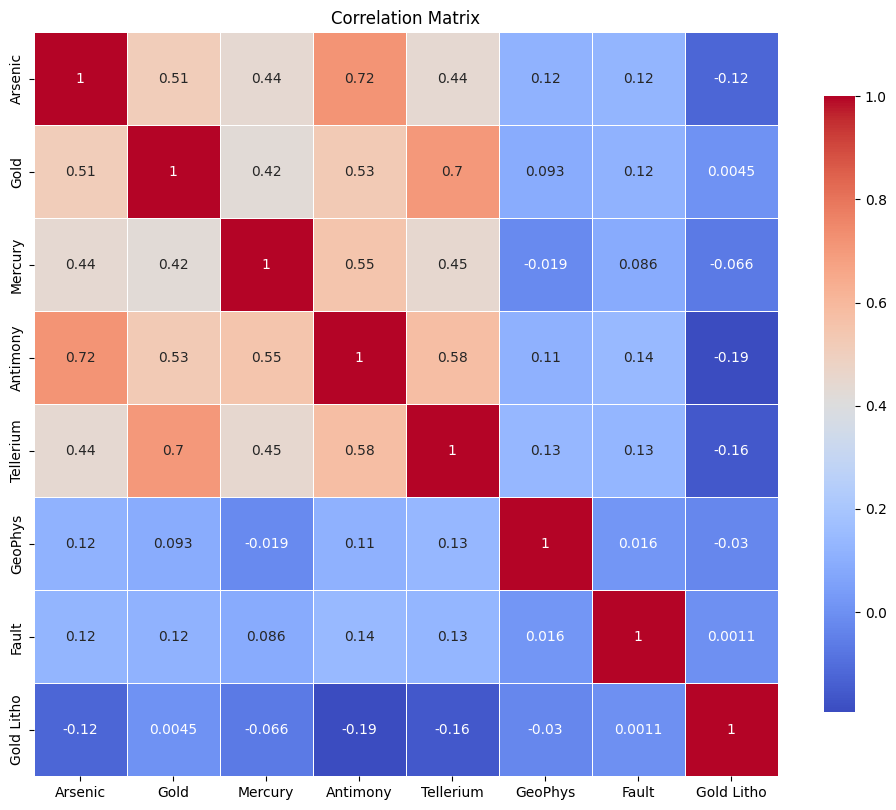

In [41]:
num_rasters = len(tif_files_and_Geophys)
raster_data = []

# Flatten each raster and append to the list
for i in range(num_rasters):
    with rasterio.open(tif_files_and_Geophys[i]) as src:
        data = src.read(1).flatten()
        raster_data.append(data)

#Create a DataFrame from flattened raster data and gold raster data
df = pd.DataFrame(raster_data).T
df['Gold_Litho'] = gold_labels.flatten()
# Calculate correlation matrix
correlation_matrix = df.corr()

element_names = ['Arsenic', 'Gold', 'Mercury', 'Antimony', 'Tellerium', 'GeoPhys', 'Fault', 'Gold Litho']
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            square=True,
            cbar_kws={'shrink': .8},
            annot_kws={"size": 10},
            linewidths=.5,
            xticklabels=element_names,
            yticklabels=element_names)

plt.savefig('correlation_matrix.png')
plt.title('Correlation Matrix')
plt.show()

In [42]:
#setting grid
cell_size = 0.005
width = src.width * transform.a
height = src.height * abs(transform.e)
xmin = transform.c
ymax = transform.f
xmax = xmin + width
ymin = ymax - height

#applying grid
x, y = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymax, ymin, -cell_size))
x = x.flatten()
y = y.flatten()

grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y)
).buffer(cell_size / 2, cap_style=3)

#seperating training and testing set based on grid
n_samples = len(grid)

n_train = int(n_samples * (1 - 0.2))
n_test = n_samples - n_train

train_grid = grid.sample(n=n_train, random_state=42)
test_grid = grid.drop(train_grid.index)

train_mask = rasterize(
    shapes=train_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

test_mask = rasterize(
    shapes=test_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

train_labels = gold_labels.squeeze() * train_mask
test_labels = gold_labels.squeeze() * test_mask

train_features_list = []
test_features_list = []

for tif_file in tif_files_and_Geophys:
    with rasterio.open(tif_file) as src:
        data = src.read(1)

        train_data = data * train_mask
        test_data = data * test_mask

        train_features_list.append(train_data)
        test_features_list.append(test_data)

train_features = np.stack(train_features_list, axis=-1)
test_features = np.stack(test_features_list, axis=-1)

In [43]:
from abc import update_abstractmethods

train_features = train_features.reshape(train_features.shape[0] * train_features.shape[1], train_features.shape[2])
train_labels = train_labels.reshape(train_labels.shape[0] * train_labels.shape[1])
test_features = test_features.reshape(test_features.shape[0] * test_features.shape[1], test_features.shape[2])
test_labels = test_labels.reshape(test_labels.shape[0] * test_labels.shape[1])


model = Sequential([
    Input(shape=(train_features.shape[1],)),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(2, activation='softmax'),
])

#Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {int(i): w for i, w in enumerate(class_weights)}

#Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])


#Fit the model with sample_weight
sample_weights = np.array([class_weights_dict[label] for label in train_labels])
model.fit(train_features, train_labels, epochs=200, validation_data=(test_features, test_labels), sample_weight=sample_weights)

Epoch 1/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6518 - loss: 5.2441 - val_accuracy: 0.9181 - val_loss: 0.2179
Epoch 2/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.6997 - loss: 0.5519 - val_accuracy: 0.9194 - val_loss: 0.2131
Epoch 3/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7139 - loss: 0.5166 - val_accuracy: 0.9518 - val_loss: 0.1908
Epoch 4/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7363 - loss: 0.5035 - val_accuracy: 0.9448 - val_loss: 0.1783
Epoch 5/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7521 - loss: 0.4972 - val_accuracy: 0.9524 - val_loss: 0.1747
Epoch 6/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7587 - loss: 0.4981 - val_accuracy: 0.9362 - val_loss: 0.2117
Epoch 7/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7638 - loss: 0.4948 - val_accuracy: 0.9409 - val_loss: 0.1888
Epoch 8/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7609 -

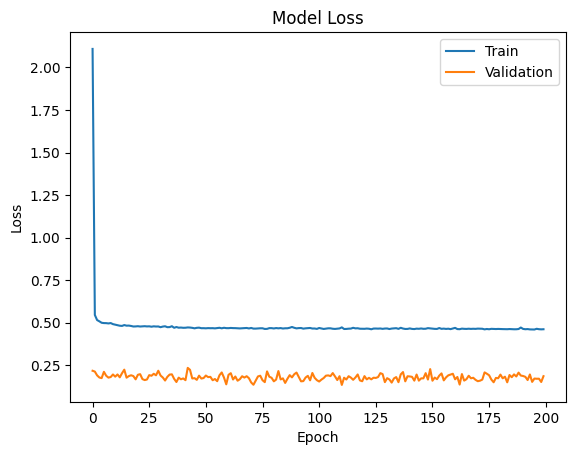

In [44]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

In [142]:
#generating data from testing data
predictions = model.predict(test_features)

3280/3280 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


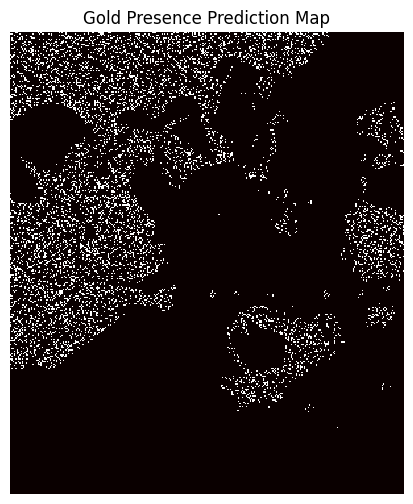

In [143]:
plt.figure(figsize=(10, 6))
#class with the highest probability
predicted_labels = np.argmax(predictions, axis=1).reshape(gold_labels.shape[0], gold_labels.shape[1])
plt.imshow(predicted_labels, cmap="hot", interpolation="nearest")
plt.title("Gold Presence Prediction Map")
plt.axis("off")
plt.savefig('gold_presence_heatmap.png')
plt.show()

In [144]:
#saving heatmap as raster for arc visualization
with rasterio.open(tif_files_and_Geophys[0]) as src:
    profile = src.profile

profile.update({
    'dtype': rasterio.float32,
    'count': predictions.shape[-1]
})


with rasterio.open("gold_presence_soil.tif", "w", **profile) as dst:
    for i in range(predictions.shape[-1]):
        dst.write(predictions[:, i].astype(rasterio.float32).reshape(gold_labels.shape[0], gold_labels.shape[1]), i + 1)

print("Heatmap exported as gold_presence_heatmap.tif")

Heatmap exported as gold_presence_heatmap.tif


In [145]:
with rasterio.open("gold_presence_soil.tif") as src:

    data = src.read(1)
    profile = src.profile

    # Convert decimal values to 1's and 0's
    data[data > 0.5] = 1
    data[data <= 0.5] = 0

    #Convert to integers
    data = data.astype(np.uint8)

    # Update the raster file
    with rasterio.open("gold_presence_soil.tif", "w", **profile) as dst:
        dst.write(data, 1)

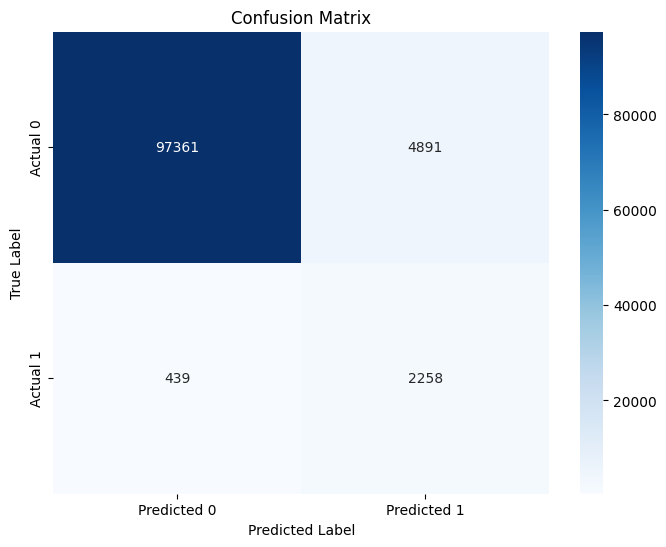

Accuracy: 0.949213427474297
Precision: 0.31584837040145475
Recall: 0.8372265480163145
F1 Score: 0.4586634166158846


In [136]:
true_labels = test_labels.flatten()
predicted_labels = np.argmax(predictions, axis=1).flatten()
#confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#  heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

3280/3280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


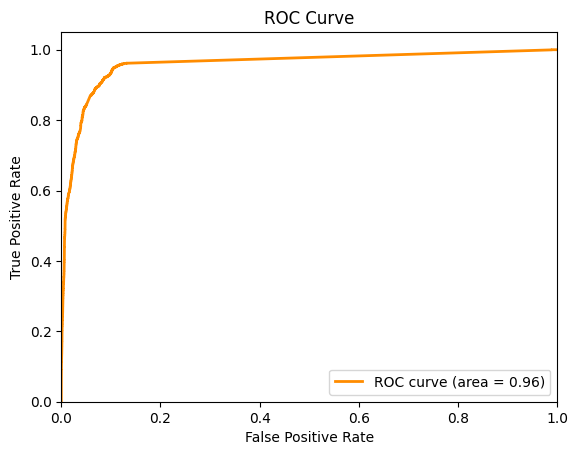

In [118]:
y_pred_prob = model.predict(test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()